# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

**Contributions**<br/>
All teammates (Jan Bauer, Maida Sabotic, Giuseppe Scafiti) contributed equally to this assignment

First part:
- Implement linear regression model 
    - using least squares method
    - implement directly using the NumPy package

Second part:
- regularization
- polynomial basis expansion
- cross validation
- scikit-learn: https://scikit-learn.org/

You will need to use the following:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

For the purpose of testing, we’ll use the winequality dataset. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality In order to make it easier to import the dataset, we’ve converted the data to the numpy array format and shuffled it so that you can start the practical directly. The dataset is available on the course website. 

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. You can load the data from the files as follows:

In [3]:
# load the dataset
# X is a matrix such that each row stores a data record 
# y is a vector of the corresponding labels of the records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a matrix with shape {}, which has {} records and {} attributes.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a matrix with shape (4898, 11), which has 4898 records and 11 attributes.
y is a vector with 4898 values, which stores the corresponding labels of the data records in X


In order to get consistent results, all students should use the same 80% of the data as training
data. We’ll use the remaining as test data. To achieve this split run the following:

In [4]:
# The function splits the dataset into the training dataset and the test dataset.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset, 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use 80% of the data as training data

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


We’ll not touch the test data except for reporting the errors of our learned models

## Understanding What We’re Predicting

Before we get to training a linear model on the data and using it to make predictions, let’s look
at the spread of y values on the training set. The values are integers between 3 and 9 indicating
the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y values appearing in the training data.

<BarContainer object of 7 artists>

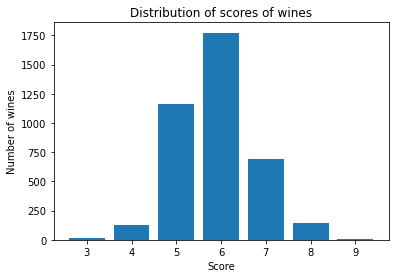

In [5]:
#@title
# Task 1: 
# the function takes the training dataset as the input, and make the bar chart
def plot_bar_chart_score(y_train) ->  dict:
        hist = {}
        for i in y_train:
            hist[i] = hist.get(i, 0) + 1
        return hist
counted = plot_bar_chart_score(y_train)
hist_new = np.array(list(counted.items())) 
hist_n=hist_new.T
plt.xlabel('Score')
plt.ylabel('Number of wines')
plt.title('Distribution of scores of wines')
plt.bar(hist_n[0,:],hist_n[1,:])

### **Task 2** 
Implement the trivial predictor, which uses the average value of y on the training set as the prediction for ever datapoint. 

In [6]:
#@title
# Task 2: implement the simplest predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
     mean=np.mean(y_train)
     return mean
y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The simplest predictor returns the average value.
def simplest_predictor(X_test, y_train_avg):
  return y_train_avg


Average of y on the training label values is 5.878764675855028


### **Task 3**
Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data. We should hope that our models beat at lease this baseline. 

In [7]:
# We will evaluate our simplest predictor here. 
# Implement a function that can report the mean squared error 
# of a predictor on the given test data
# Input: test dataset and predictor
# Output: mean squared error of the predictor on the given test data
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    err = (y_predicted-y_test)
    mse = (err.T @ err)/X_test.shape[0]
    return mse

# use the above function test_data to evaluate the simplest predictor
# we use the lambda function here to pass the function simplest_predictor to the evaluator.
mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

# Report the result
print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Linear Model Using Least Squares

Let us first fit a linear regression model and then calculate the training and test error. We’ll
actually use the closed form solution of the least squares estimate for the linear model. 


### **Task 4**
Is it strictly necessary to standardize the data for the linear model using the least squares method? Why?

(Add the answer to Task 4 here in text)

### **Task 5**
Standardize the data, i.e., make the data for every feature have mean 0 and variance 1. 

We do the standardization using the training data, and we need to remember the means and
the standard deviations so that they can be applied to the test data as well. Apply the
standardization so that every feature in the training data has mean 0 and variance 1. Apply
the same transformation to the test data. 

In [8]:
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    mean = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    X_std = (X-mean)/std
    return X_std, mean, std

X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [9]:
# TODO: Standardize the test data using the mean and standrad deviation you computed for the training data
X_test_std = (X_test-X_train_mean)/X_train_std_div
print(X_test_std.shape)

(980, 11)


### **Task 6**
Implement the linear model predictor, and report the mean squared error using the linear model on the training and test data.

We will do this in several steps. We need to implement the function for computing the parameters based on the training dataset. Note we need to add the bias column to the dataset. 

In [10]:
# the function adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    # Here we create an array of 1 which has the same length of the number of the X's rows 
    vector=np.repeat(1,X.shape[0])
    # Now we expand the dimendion of the array in order to get the dim of Nx1
    vector=np.expand_dims(vector,axis=1)
    # As next we add the vector to the X Matrix
    X_out = np.append(vector,X, axis=1)
    return X_out

# The function computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the dataset
    X = expand_with_ones(X_input)
    T = np.linalg.inv(X.T @ X) @ X.T @ y
    T = np.asarray(T)
    return T
# train the linear model parameters
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)
print(w)

w: (12,)
[ 5.87876468e+00  5.70365710e-02 -1.83384219e-01 -4.04067444e-03
  4.09097280e-01 -8.17517111e-03  5.92929519e-02 -3.56633675e-03
 -4.36936781e-01  9.87381161e-02  6.53325059e-02  2.42495455e-01]


We then implement the linear model predictor given the dataset and the parameters. 

In [11]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    y_predicted = X @ w
    return y_predicted
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


We can now evaluate our linear model predictor on the test dataset. 

In [12]:
# use the function test_data to evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283469


## Learning Curves

Let us see if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, our guess should be that it may either be underfitting or be about right.

Starting with 20 datapoints, we’ll use training datasets of increasing size, in increments of 20 up to about 600 datapoints. For each case train the linear model only using the first n elements of
the training data. Calculate the training error (on the data used) and the test error (on the full test set). Plot the training error and test error as a function of the size of the dataset used for
training.

### **Task 7** 
Implement a function that evaluates the linear model over the training dataset with the input size.
The function takes a dataset and the split coefficient as inputs, and
1. splits the data to training and test datasets,
2. standardizes the data,
3. trains the linear model, and
4. reports the mse of the linear model predictor on both training and test datasets. 

In [13]:
# Input: dataset and split coefficient
# Output: mse of the linear model predictor on both the training and test datasets
def train_and_test(X, y, split_coeff):
    #shuffle the data before splitting it.
    np.random.seed(42)
    permutation = np.random.permutation(X.shape[0])
    X = np.take(X, permutation,axis=0)
    y = np.take(y, permutation,axis=0)
    ## 1.Split the data into training and test data.
    #The first m entries from X will be taken as the training data.
    #The last (n - m) entries from X will be used as test data.
    X_train, y_train, X_test, y_test = split_data(X, y, split_coeff)
    ## 2. Standardize the data
    # Start by standardizing the training data
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)  
    # Standardization, using the mean and the sd we already calculated in the task 5
    X_test_std = (X_test-X_train_mean)/X_train_std_div
    ## 3. Train the linear model using the function built in the task 6
    w = least_squares_compute_parameters(X_train_std, y_train)
    ## 4. We use the given mse comand of the previous task 
    mse_train = test_data(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))
    mse_test  = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
    return mse_train, mse_test

mse_train, mse_test = train_and_test(X, y, 0.8)
print('MSE using Linear Models')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


MSE using Linear Models
-----------------------

MSE (Training) = 0.5497
MSE (Testing)  = 0.6283


### **Task 8**
Report the learning curves plot. Also, explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

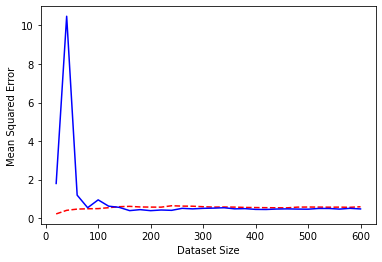

0.39079527268413167


array([[2.00000000e+01, 1.80191135e+00],
       [4.00000000e+01, 1.04801639e+01],
       [6.00000000e+01, 1.19568316e+00],
       [8.00000000e+01, 5.42940153e-01],
       [1.00000000e+02, 9.50829683e-01],
       [1.20000000e+02, 6.23111777e-01],
       [1.40000000e+02, 5.62862466e-01],
       [1.60000000e+02, 3.92420088e-01],
       [1.80000000e+02, 4.43614932e-01],
       [2.00000000e+02, 3.90795273e-01],
       [2.20000000e+02, 4.24902604e-01],
       [2.40000000e+02, 4.07409572e-01],
       [2.60000000e+02, 5.10633652e-01],
       [2.80000000e+02, 4.83681955e-01],
       [3.00000000e+02, 5.11097153e-01],
       [3.20000000e+02, 5.22454053e-01],
       [3.40000000e+02, 5.41695392e-01],
       [3.60000000e+02, 4.84855087e-01],
       [3.80000000e+02, 4.94953364e-01],
       [4.00000000e+02, 4.56673344e-01],
       [4.20000000e+02, 4.51751906e-01],
       [4.40000000e+02, 4.74307909e-01],
       [4.60000000e+02, 4.83135834e-01],
       [4.80000000e+02, 4.72533917e-01],
       [5.000000

In [17]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
   # Select the train_size elements of the data for the estimation
    X_est = X[:train_size]
    y_est = y[:train_size]
    # Use the above defined function to calculate the training error and test error
    mse_train, mse_test = train_and_test(X_est, y_est, 0.8)
    # Add them to mse_train_v and mse_test_v, respectively
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)

# The below code outputs the plot of mse from different training sizes
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

#Finding out minimum
c = np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20)
A = np.vstack((c,mse_test_v)).T
print(np.min(A))
A

(Add the answer to Task 8 here in text)

Here it can be observed, that the minimun test error equals to 0.39 (approx.) using more or less 200 observations. At the beginning we can also observe that the test error is much more greater than the training error which indicate the model is underfitted. However, since the test error reachs out the same level of the training error as soon as more than approx 140 observations get used, we think that the minimun data size to obtain the optimal test error should be around 200. 

## Polynomial Basis Expansion with Ridge and Lasso

For this part use the following from the scikit-learn package. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html



You will need the use the following:

In [18]:
# You will need the following libs. 
# Fell free to import other libs. 

# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

Try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. You should pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [37]:
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree, interaction_only=False, include_bias=False, order='C')
    # Note that we exclude the bias term. This is done to prevent problems when standardizing the data later on
    return poly.fit_transform(X)

new_X =expand_basis(X, 2)
print(new_X.shape)

(4898, 77)


### **Task 10**
Prepare the training, test and validation data using the expanded dataset. Expand and standardize the the data. 

Hints: you can use `StandardScaler` and `std_scaler` to standardize the data

In [35]:
# TODO: the training, test and validation data using the expanded dataset.
# The code below is just for compilation. 
# You need to replace it by your own code.
def prepare_data(X, y, degree):
    # You need expand the basis of the data, and do standardization
    X=expand_basis(X,degree)
    # training data & test data using the function split_data
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)
    # Standardization of the training data using the code by task 7
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)  
    # Then standardize the test data using the same code by task 7
    X_test_std = (X_test-X_train_mean)/X_train_std_div
    # Next step: split the training data to training and validation data using a split coefficient of 0.8
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train_std, y_train, 0.8)
    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test
# Activation and expansion of data
X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyper parameter lambda for Ridge and Lasso using the validation data. 


Ridge lambda: 0.01
Lasso lambda: 0.01


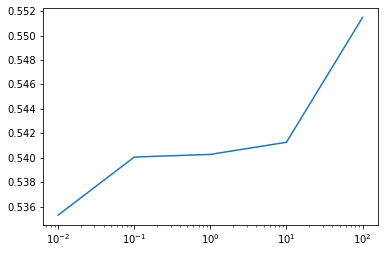

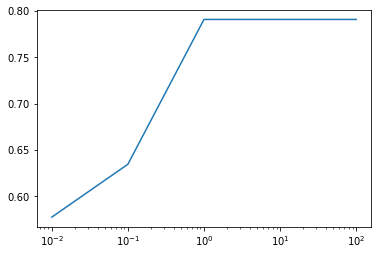

In [36]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that has the minimal mse
# We use is_ridge to indicate the model we consider. 
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    for pow_lam in range(-2, 3):
        lam = 10 ** pow_lam
        if is_ridge:
          regression = Ridge(lam).fit(X_train_n, y_train_n)
        else:
          regression = Lasso(lam).fit(X_train_n, y_train_n)
        # Get the predictions for the validation set
        y_pred = regression.predict(X_train_v)
        # Calculate the mse
        mse = np.sum((y_pred - y_train_v) ** 2) / y_train_v.shape[0]
        # Add the mse when using the hyperparameter lam
        mse_arr.append(mse) 
        lam_arr.append(lam)

    # get the index of the lambda value that has the minimal mse
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal values for lambda for Ridge and Lasso, train these models using these hyperparameters on the full training data. Then report
the training and test error.

In [38]:
# TODO: train the Ridge and Lasso models using their best parameters, and
#       report their mse
# Ridge Regression
regression = Ridge(lam_ridge).fit(X_train, y_train)
y_train_prediction_Ridge = regression.predict(X_train)
y_test_prediction_Ridge = regression.predict(X_test)
mse_ridge_train = np.sum((y_train-y_train_prediction_Ridge)**2) / y_train.shape[0]
mse_ridge_test = np.sum((y_test-y_test_prediction_Ridge)**2) / y_test.shape[0]
# Lasso Regression
regression = Lasso(lam_lasso).fit(X_train, y_train)
y_train_prediction_Lasso = regression.predict(X_train)
y_test_prediction_Lasso = regression.predict(X_test)
mse_lasso_train = np.sum((y_train-y_train_prediction_Lasso)**2) / y_train.shape[0]
mse_lasso_test = np.sum((y_test-y_test_prediction_Lasso)**2) / y_test.shape[0]

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (lam_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (lam_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 0 polynomial expansion and lambda = 0.0100
--------------------------------------------------------------------------------

MSE (Training) = 0.5000
MSE (Testing)  = 0.5118


For Lasso with using degree 0 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.5389
MSE (Testing)  = 0.5388


C:\Users\Giuse\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1040.8175435885678, tolerance: 0.304341322103114
  model = cd_fast.enet_coordinate_descent(


## Larger Degrees



### **Task 13**
Try using higher degree basis expansion. You may want to use k-fold cross validation to determine
the values of hyperparameters rather than just keeping a validation set. 

Hints: Use `KFold` to do this automatically. 

Ridge lambda: 0.01
Lasso lambda: 0.01
Ridge lambda: 0.01
Lasso lambda: 0.01
Ridge lambda: 1
Lasso lambda: 0.01
Ridge lambda: 10
Lasso lambda: 0.01
For Ridge Regression with using degree 10 polynomial expansion and lambda = 10.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.3608
MSE (Testing)  = 1.0190


For Lasso with using degree 0 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.4590
MSE (Testing)  = 0.5310


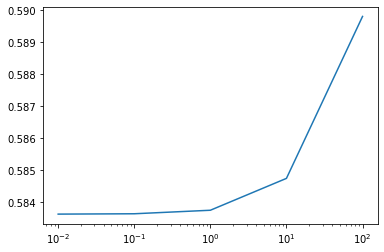

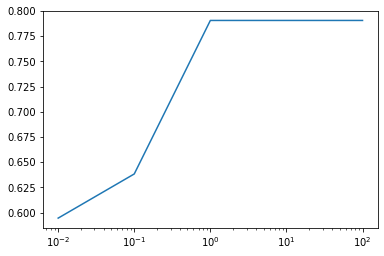

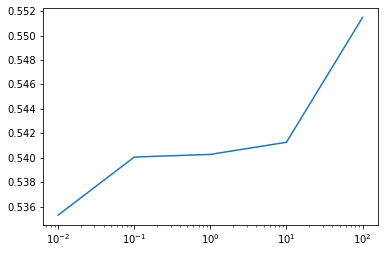

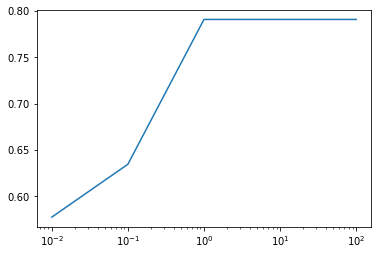

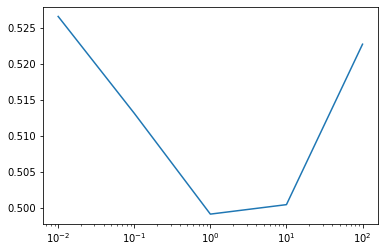

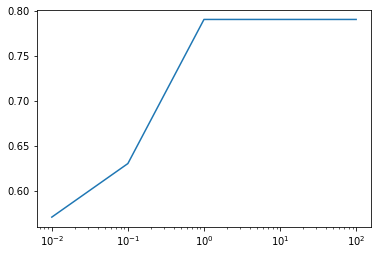

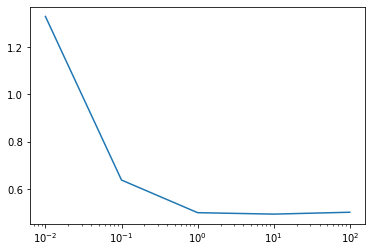

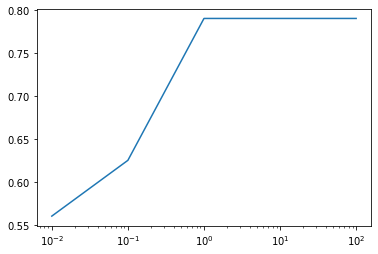

In [41]:
# KFold
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# TODO: Try using higher degree basis expansion. Find the degree that gives the minimal mse. 

for i in range(1,5):
    kf = KFold(n_splits=10, random_state=None, shuffle=True)
    kf.get_n_splits(X)
    X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, i)
    lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
    lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)
    print("Ridge lambda:", lam_ridge)
    print("Lasso lambda:", lam_lasso)
    # Ridge Regression
    regression = Ridge(lam_ridge).fit(X_train, y_train)
    y_train_prediction_Ridge = regression.predict(X_train)
    y_test_prediction_Ridge = regression.predict(X_test)
    mse_ridge_train = np.sum((y_train-y_train_prediction_Ridge)**2) / y_train.shape[0]
    mse_ridge_test = np.sum((y_test-y_test_prediction_Ridge)**2) / y_test.shape[0]
    # Lasso Regression
    regression = Lasso(lam_lasso).fit(X_train, y_train)
    y_train_prediction_Lasso = regression.predict(X_train)
    y_test_prediction_Lasso = regression.predict(X_test)
    mse_lasso_train = np.sum((y_train-y_train_prediction_Lasso)**2) / y_train.shape[0]
    mse_lasso_test = np.sum((y_test-y_test_prediction_Lasso)**2) / y_test.shape[0]

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (lam_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (lam_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)